In [1]:
!pip install -q pyomo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.2 MB/s eta 0:00:00


In [2]:
!apt-get install -y -qq coinor-cbc

Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 123621 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3) ...
Selecting previously unselected package coinor-libcbc3:amd64.
Preparing to unpack .../4-coinor-libcbc3_2.10.7+ds1-1_amd64.deb ...
Unpacking coinor-libcbc3:

In [2]:
import pandas as pd
import pyomo.environ as pyo

In [3]:
df=pd.ExcelFile('Housing Problem - parameter values.xlsx')
df.sheet_names

['number_of_apartments',
 'profit_height_69',
 'profit_height_120',
 'profit_height_168']

In [4]:
number_of_apartments=pd.read_excel('Housing Problem - parameter values.xlsx', sheet_name='number_of_apartments')
number_of_apartments

,area,configuration,no_of_apartments
0,36,aa,4
1,36,ab,2
2,36,ac,2
3,36,bb,0
4,36,bc,0
...,...,...,...
105,131,cd,0
106,131,ce,2
107,131,dd,0
108,131,de,2


In [6]:
profit_height_69=pd.read_excel('Housing Problem - parameter values.xlsx', sheet_name='profit_height_69')
profit_height_69 #120 and 168 can be also added and used for analysis (model need to be modified or just calculated separately)

,sector,area,owner,profit
0,social,36,corporation,-25085.659379
1,social,36,investor,14925.772676
2,social,36,private,-213932.318684
3,social,42,corporation,-27602.151343
4,social,42,investor,-12842.016761
...,...,...,...,...
85,free,96,investor,-60901.541256
86,free,96,private,319548.547229
87,free,131,corporation,-309458.504063
88,free,131,investor,-163462.885816


In [7]:
#added to check code
df=pd.ExcelFile('Housing Problem - parameter values.xlsx')
number_of_apartments=pd.read_excel('Housing Problem - parameter values.xlsx', sheet_name='number_of_apartments')
profit_height_69=pd.read_excel('Housing Problem - parameter values.xlsx', sheet_name='profit_height_69')



In [8]:

def housing_problem(profit_height_69, number_of_apartments, K=23, alpha=None, beta=None, gamma=None, delta=None):
    model = pyo.ConcreteModel('House Problem')

    # Sets
    model.Sector = pyo.Set(initialize=profit_height_69['sector'].unique().tolist())
    model.Area = pyo.Set(initialize=profit_height_69['area'].unique().tolist())
    model.Owner = pyo.Set(initialize=profit_height_69['owner'].unique().tolist())
    model.Floor_Design = pyo.Set(initialize=number_of_apartments['configuration'].unique().tolist())

    # Variables
    model.X = pyo.Var(model.Floor_Design, domain=pyo.NonNegativeIntegers)
    model.Y = pyo.Var(model.Sector, model.Area, model.Owner, domain=pyo.NonNegativeIntegers)
    model.W = pyo.Var(model.Floor_Design, model.Owner, domain=pyo.NonNegativeIntegers)
    model.Z = pyo.Var(model.Area, model.Owner, domain=pyo.NonNegativeIntegers)

    # Parameters
    model.K = pyo.Param(default=23, mutable=False)
    model.R = pyo.Param(model.Area, model.Floor_Design, initialize=lambda model, j, v:
                        number_of_apartments.loc[(number_of_apartments['area'] == j) &
                                                 (number_of_apartments['configuration'] == v), 'no_of_apartments'].item(), default=0)
    model.O = pyo.Param(model.Sector, model.Area, model.Owner, initialize=lambda model, i, j, h:
                        profit_height_69.loc[(profit_height_69['sector'] == i) &
                                             (profit_height_69['area'] == j) &
                                             (profit_height_69['owner'] == h), 'profit'].item(), default=0)

    # Flexible Parameter Initialization
    model.alpha = pyo.Param(model.Sector, model.Owner, initialize=lambda model, i, h:
                            alpha.get((i, h), {('social', 'corporation'): 40,
                                               ('middle', 'corporation'): 50,
                                               ('free', 'investor'): 60}.get((i, h), 0)) if alpha else
                            {('social', 'corporation'): 40, ('middle', 'corporation'): 50, ('free', 'investor'): 60}.get((i, h), 0))

    model.beta = pyo.Param(model.Sector, initialize=lambda model, i:
                           beta.get(i, {'social': 0.4, 'middle': 0.4, 'free': 0}.get(i, 0)) if beta else
                           {'social': 0.4, 'middle': 0.4, 'free': 0}.get(i, 0))

    model.gamma = pyo.Param(model.Sector, initialize=lambda model, i:
                            gamma.get(i, {'social': 40, 'middle': 50, 'free': 0}.get(i, 0)) if gamma else
                            {'social': 40, 'middle': 50, 'free': 0}.get(i, 0))

    model.delta = pyo.Param(model.Owner, initialize=lambda model, h:
                            delta.get(h, {'investor': 0.7}.get(h, 0)) if delta else
                            {'investor': 0.7}.get(h, 0))

    # Objective Function
    @model.Objective(sense=pyo.maximize)
    def obj(model):
        return pyo.quicksum(model.O[i, j, h] * model.Y[i, j, h] for i in model.Sector for j in model.Area for h in model.Owner)

    # Constraints
    @model.Constraint()
    def total_floors(model):
        return pyo.quicksum(model.X[v] for v in model.Floor_Design) == K

    @model.Constraint(model.Area)
    def total_consistency(model, j):
        return pyo.quicksum(model.R[j, v] * model.X[v] for v in model.Floor_Design) == pyo.quicksum(model.Y[i, j, h] for i in model.Sector for h in model.Owner)

    @model.Constraint(model.Floor_Design)
    def owner_conf(model, v):
        return pyo.quicksum(model.W[v, h] for h in model.Owner) == model.X[v]

    @model.Constraint(model.Area, model.Owner)
    def one_owner_floor(model, j, h):
        return model.Z[j, h] == pyo.quicksum(model.W[v, h] * model.R[j, v] for v in model.Floor_Design)

    @model.Constraint(model.Area, model.Owner)
    def apt_by_own_area(model, j, h):
        return model.Z[j, h] == pyo.quicksum(model.Y[i, j, h] for i in model.Sector)

    @model.Constraint(model.Sector)
    def min_perc_sect(model, i):
        return pyo.quicksum(model.Y[i, j, h] for j in model.Area for h in model.Owner) >= model.beta[i] * pyo.quicksum(model.Y[l, j, h] for l in model.Sector for j in model.Area for h in model.Owner)

    @model.Constraint(model.Sector)
    def min_ave_floor_area(model, i):
        return pyo.quicksum(j * model.Y[i, j, h] for j in model.Area for h in model.Owner) >= model.gamma[i] * pyo.quicksum(model.Y[i, j, h] for j in model.Area for h in model.Owner)

    @model.Constraint(model.Sector, model.Area, model.Owner)
    def min_floor_area(model, i, j, h):
        return (model.Y[i, j, h] == 0 if j < model.alpha[i, h] else pyo.Constraint.Skip)

    @model.Constraint(model.Area)
    def no_free_corp(model, j):
        return model.Y['free', j, 'corporation'] == 0

    @model.Constraint(model.Owner)
    def sector_ownership_req(model, h):
        return pyo.quicksum(model.Y[i, j, h] for i in model.Sector for j in model.Area) >= model.delta[h] * pyo.quicksum(model.Y[i, j, p] for i in model.Sector for j in model.Area for p in model.Owner)

    return model

model=housing_problem (profit_height_69, number_of_apartments, K=23)


In [9]:
solver = pyo.SolverFactory('cbc')
results = solver.solve(model)

# Display total profit (objective value)
total_profit = pyo.value(model.obj)
print(f"Total Profit: {total_profit}")

# Display optimal values of alpha, beta, gamma, and delta
print("\nOptimal Values of Parameters:")
for i in model.Sector:
    for h in model.Owner:
        print(f"alpha[{i}, {h}] = {pyo.value(model.alpha[i, h])}")

for i in model.Sector:
    print(f"beta[{i}] = {pyo.value(model.beta[i])}")
    print(f"gamma[{i}] = {pyo.value(model.gamma[i])}")

for h in model.Owner:
    print(f"delta[{h}] = {pyo.value(model.delta[h])}")

# Display the design for each floor
print("Floor Design:")
for v in model.Floor_Design:
    if pyo.value(model.X[v])!=0:
        print(f"Design {v}: {pyo.value(model.X[v])} floors")

# Display the owner for each floor design
print("\nOwner for Each Floor Design:")
for v in model.Floor_Design:
    for h in model.Owner:
        if pyo.value(model.W[v,h])!=0:
            print(f"Design {v}, Owner {h}: {pyo.value(model.W[v,h])} floors")

# Optionally, display the number of apartments for each sector, area, and owner
print("\nNumber of Apartments for Each Sector, Area, and Owner:")
for i in model.Sector:
    for j in model.Area:
        for h in model.Owner:
            if pyo.value(model.Y[i,j,h])!=0:
             print(f"Sector {i}, Area {j}, Owner {h}: {pyo.value(model.Y[i,j,h])} apartments")



Total Profit: 17483910.86302152

Optimal Values of Parameters:
alpha[social, corporation] = 40
alpha[social, investor] = 0
alpha[social, private] = 0
alpha[middle, corporation] = 50
alpha[middle, investor] = 0
alpha[middle, private] = 0
alpha[free, corporation] = 0
alpha[free, investor] = 60
alpha[free, private] = 0
beta[social] = 0.4
gamma[social] = 40
beta[middle] = 0.4
gamma[middle] = 50
beta[free] = 0
gamma[free] = 0
delta[corporation] = 0
delta[investor] = 0.7
delta[private] = 0
Floor Design:
Design aa: 11.0 floors
Design ac: 1.0 floors
Design cc: 1.0 floors
Design cd: 1.0 floors
Design ee: 9.0 floors

Owner for Each Floor Design:
Design aa, Owner investor: 11.0 floors
Design ac, Owner investor: 1.0 floors
Design cc, Owner investor: 1.0 floors
Design cd, Owner corporation: 1.0 floors
Design ee, Owner private: 9.0 floors

Number of Apartments for Each Sector, Area, and Owner:
Sector social, Area 36, Owner investor: 46.0 apartments
Sector social, Area 42, Owner investor: 27.0 apartm

Performing sensitivity analysis for owner: corporation
Performing sensitivity analysis for owner: investor
Performing sensitivity analysis for owner: private


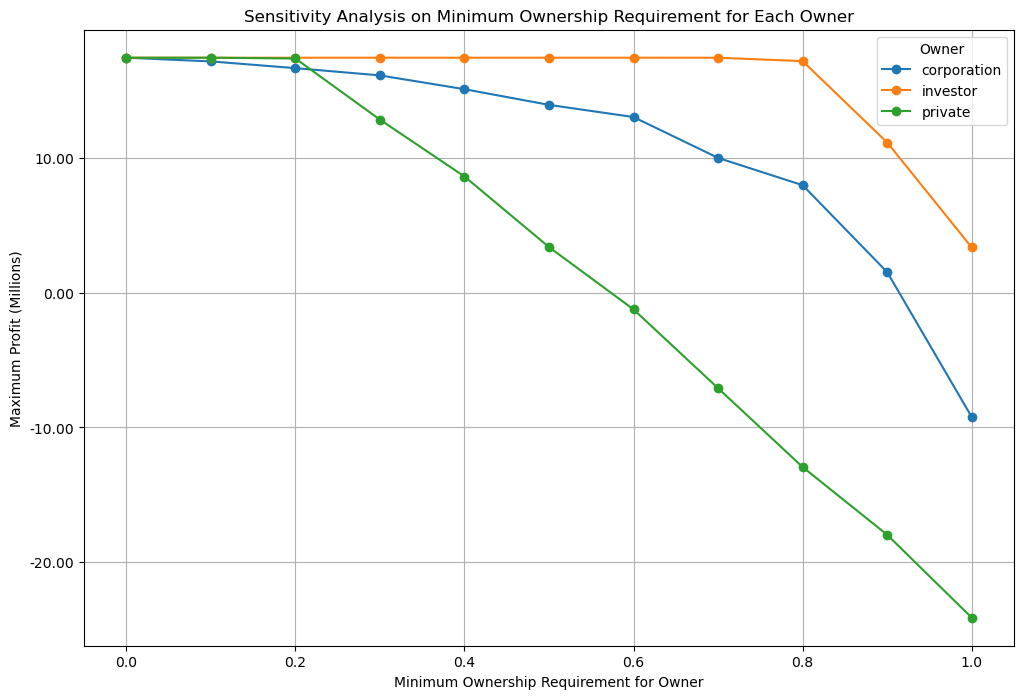


Results for owner: corporation
    delta  maximum_profit  maximum_profit_millions
0     0.0    1.748391e+07                17.483911
1     0.1    1.721002e+07                17.210021
2     0.2    1.670895e+07                16.708948
3     0.3    1.617012e+07                16.170121
4     0.4    1.514326e+07                15.143263
5     0.5    1.397866e+07                13.978656
6     0.6    1.307250e+07                13.072501
7     0.7    1.003470e+07                10.034699
8     0.8    8.004623e+06                 8.004623
9     0.9    1.543106e+06                 1.543106
10    1.0   -9.230407e+06                -9.230407

Results for owner: investor
    delta  maximum_profit  maximum_profit_millions
0     0.0    1.748391e+07                17.483911
1     0.1    1.748391e+07                17.483911
2     0.2    1.748391e+07                17.483911
3     0.3    1.748391e+07                17.483911
4     0.4    1.748391e+07                17.483911
5     0.5    1.748391

In [10]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Optional: Import ticker for formatting
import matplotlib.ticker as ticker

def sensitivity_analysis_per_owner(profit_height_69, number_of_apartments, K=23):
    # Get the list of owners from the data
    owners = profit_height_69['owner'].unique().tolist()

    # Define delta values to test
    delta_values = np.linspace(0, 1, 11)  # From 0.0 to 1.0 in increments of 0.1

    # Initialize a dictionary to store results for each owner
    results = {h: [] for h in owners}

    for owner in owners:
        print(f"Performing sensitivity analysis for owner: {owner}")
        for delta_value in delta_values:
            # Set delta for the current owner
            delta = {h: 0.0 for h in owners}  # Set delta for other owners to 0
            delta[owner] = delta_value  # Vary delta for the current owner

            # Ensure the sum of delta values does not exceed 1
            total_delta = sum(delta.values())
            if total_delta > 1.0:
                print(f"Skipping delta = {delta_value} for owner {owner} as total delta exceeds 1.")
                continue  # Skip this iteration

            # Build the model with the current delta
            model = housing_problem(profit_height_69, number_of_apartments, K=K, delta=delta)

            # Solve the model
            solver = pyo.SolverFactory('cbc')  # Replace 'cbc' with your solver of choice
            solver.options['tmlim'] = 60  # Set a time limit if desired
            result = solver.solve(model, tee=False)

            # Check if the solution is optimal
            if (result.solver.status == pyo.SolverStatus.ok) and \
               (result.solver.termination_condition == pyo.TerminationCondition.optimal):
                # Retrieve the maximum profit
                maximum_profit = pyo.value(model.obj)

                # Store the results
                results[owner].append({
                    'delta': delta_value,
                    'maximum_profit': maximum_profit
                })
            else:
                print(f"Model not solved optimally for delta = {delta_value} for owner {owner}. Status: {result.solver.status}")
                # Store NaN or some indicator
                results[owner].append({
                    'delta': delta_value,
                    'maximum_profit': np.nan
                })

    # Convert results to DataFrames for analysis
    results_dfs = {}
    for owner in owners:
        df = pd.DataFrame(results[owner])
        df.dropna(subset=['maximum_profit'], inplace=True)  # Drop rows with NaN maximum profit
        results_dfs[owner] = df

    # Plotting the results for each owner
    plt.figure(figsize=(12, 8))
    for owner in owners:
        df = results_dfs[owner]
        if not df.empty:
            # Convert maximum profit to millions
            df['maximum_profit_millions'] = df['maximum_profit'] / 1e6
            plt.plot(df['delta'], df['maximum_profit_millions'], marker='o', label=owner)

    plt.xlabel('Minimum Ownership Requirement for Owner')
    plt.ylabel('Maximum Profit (Millions)')
    plt.title('Sensitivity Analysis on Minimum Ownership Requirement for Each Owner')
    plt.legend(title='Owner')
    plt.grid(True)

    # Formatting y-axis ticks (optional)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    plt.show()

    return results_dfs

# Example usage:
# Assuming profit_height_69 and number_of_apartments are already loaded as DataFrames
results_dfs = sensitivity_analysis_per_owner(profit_height_69, number_of_apartments, K=23)

# Display the results for each owner
for owner in results_dfs:
    print(f"\nResults for owner: {owner}")
    print(results_dfs[owner])


In [11]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Optional: Import ticker for formatting
import matplotlib.ticker as ticker

def sensitivity_analysis_on_alpha(profit_height_69, number_of_apartments, K=23):
    # Get the list of sectors, owners, and available apartment areas from the data
    sectors = profit_height_69['sector'].unique().tolist()
    owners = profit_height_69['owner'].unique().tolist()
    areas = sorted(number_of_apartments['area'].unique())

    # Define the minimum and maximum apartment areas available
    min_area = min(areas)
    max_area = max(areas)

    # Define alpha values to test for each sector-owner pair
    alpha_values = np.linspace(min_area, max_area, 10)  # Adjust the number of steps as needed

    # Initialize a dictionary to store results for each sector-owner pair
    results = {(i, h): [] for i in sectors for h in owners}

    for i in sectors:
        for h in owners:
            print(f"Performing sensitivity analysis for sector: {i}, owner: {h}")
            for alpha_value in alpha_values:
                # Set alpha for the current sector-owner pair
                alpha = {}
                for si in sectors:
                    for sh in owners:
                        # Set default alpha values for other pairs (e.g., minimum area)
                        alpha[(si, sh)] = min_area
                alpha[(i, h)] = alpha_value  # Vary alpha for the current sector-owner pair

                # Build the model with the current alpha
                model = housing_problem(profit_height_69, number_of_apartments, K=K, alpha=alpha)

                # Solve the model
                solver = pyo.SolverFactory('cbc')  # Replace 'cbc' with your solver of choice
                solver.options['tmlim'] = 60  # Set a time limit if desired
                result = solver.solve(model, tee=False)

                # Check if the solution is optimal
                if (result.solver.status == pyo.SolverStatus.ok) and \
                   (result.solver.termination_condition == pyo.TerminationCondition.optimal):
                    # Retrieve the maximum profit
                    maximum_profit = pyo.value(model.obj)

                    # Store the results
                    results[(i, h)].append({
                        'alpha': alpha_value,
                        'maximum_profit': maximum_profit
                    })
                else:
                    print(f"Model not solved optimally for alpha = {alpha_value} for sector {i}, owner {h}. Status: {result.solver.status}")
                    # Store NaN or some indicator
                    results[(i, h)].append({
                        'alpha': alpha_value,
                        'maximum_profit': np.nan
                    })

    # Convert results to DataFrames for analysis
    results_dfs = {}
    for key in results:
        df = pd.DataFrame(results[key])
        df.dropna(subset=['maximum_profit'], inplace=True)  # Drop rows with NaN maximum profit
        results_dfs[key] = df

    # Plotting the results for each sector-owner pair
    plt.figure(figsize=(12, 8))
    for key in results_dfs:
        i, h = key
        df = results_dfs[key]
        if not df.empty:
            # Convert maximum profit to millions
            df['maximum_profit_millions'] = df['maximum_profit'] / 1e6
            plt.plot(df['alpha'], df['maximum_profit_millions'], marker='o', label=f'Sector: {i}, Owner: {h}')

    plt.xlabel('Minimum Acceptable Apartment Area')
    plt.ylabel('Maximum Profit (Millions)')
    plt.title('Sensitivity Analysis on Minimum Acceptable Apartment Area for Each Sector-Owner Pair')
    plt.legend(title='Sector-Owner Pair')
    plt.grid(True)

    # Formatting y-axis ticks (optional)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    plt.show()

    return results_dfs

# Example usage:
# Assuming profit_height_69 and number_of_apartments are already loaded as DataFrames
results_dfs = sensitivity_analysis_on_alpha(profit_height_69, number_of_apartments, K=23)

# Display the results for each sector-owner pair
for key in results_dfs:
    i, h = key
    print(f"\nResults for sector: {i}, owner: {h}")
    print(results_dfs[key])


Performing sensitivity analysis for sector: social, owner: corporation


KeyboardInterrupt: 

Performing sensitivity analysis for sector: social
Performing sensitivity analysis for sector: middle
Performing sensitivity analysis for sector: free


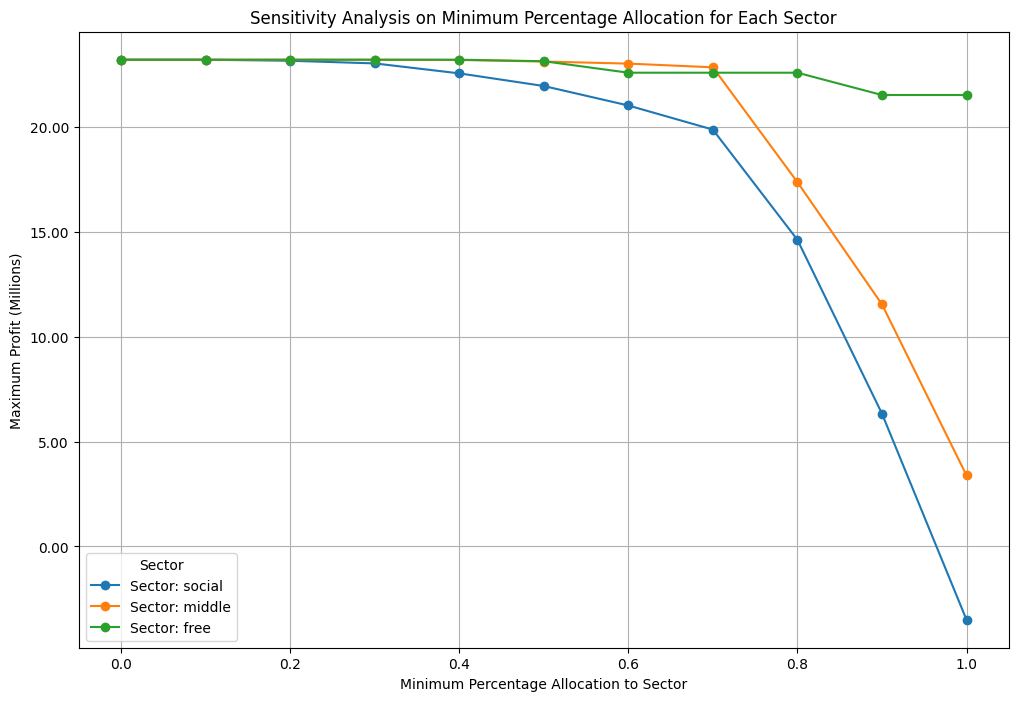


Results for sector: social
    beta  maximum_profit  maximum_profit_millions
0    0.0    2.319370e+07                23.193704
1    0.1    2.319370e+07                23.193704
2    0.2    2.314454e+07                23.144537
3    0.3    2.301846e+07                23.018456
4    0.4    2.254386e+07                22.543864
5    0.5    2.194126e+07                21.941262
6    0.6    2.101316e+07                21.013158
7    0.7    1.986351e+07                19.863514
8    0.8    1.461181e+07                14.611811
9    0.9    6.329773e+06                 6.329773
10   1.0   -3.492195e+06                -3.492195

Results for sector: middle
    beta  maximum_profit  maximum_profit_millions
0    0.0    2.319370e+07                23.193704
1    0.1    2.319370e+07                23.193704
2    0.2    2.319370e+07                23.193704
3    0.3    2.319370e+07                23.193704
4    0.4    2.318296e+07                23.182959
5    0.5    2.310623e+07                23.1

In [ ]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Optional: Import ticker for formatting
import matplotlib.ticker as ticker

def sensitivity_analysis_on_beta(profit_height_69, number_of_apartments, K=23):
    # Get the list of sectors from the data
    sectors = profit_height_69['sector'].unique().tolist()

    # Define beta values to test for each sector
    beta_values = np.linspace(0, 1.0, 11)  # From 0.0 to 1.0 in increments of 0.1

    # Initialize a dictionary to store results for each sector
    results = {i: [] for i in sectors}

    for i in sectors:
        print(f"Performing sensitivity analysis for sector: {i}")
        for beta_value in beta_values:
            # Set beta for the current sector
            beta = {}
            for si in sectors:
                beta[si] = 0.0  # Set beta for other sectors to 0
            beta[i] = beta_value  # Vary beta for the current sector

            # Ensure that the sum of beta values does not exceed 1
            total_beta = sum(beta.values())
            if total_beta > 1.0:
                print(f"Skipping beta = {beta_value} for sector {i} as total beta exceeds 1.")
                continue  # Skip this iteration

            # Build the model with the current beta
            model = housing_problem(profit_height_69, number_of_apartments, K=K, beta=beta)

            # Solve the model
            solver = pyo.SolverFactory('cbc')  # Replace 'glpk' with your solver of choice
            solver.options['tmlim'] = 60  # Set a time limit if desired
            result = solver.solve(model, tee=False)

            # Check if the solution is optimal
            if (result.solver.status == pyo.SolverStatus.ok) and \
               (result.solver.termination_condition == pyo.TerminationCondition.optimal):
                # Retrieve the maximum profit
                maximum_profit = pyo.value(model.obj)

                # Store the results
                results[i].append({
                    'beta': beta_value,
                    'maximum_profit': maximum_profit
                })
            else:
                print(f"Model not solved optimally for beta = {beta_value} for sector {i}. Status: {result.solver.status}")
                # Store NaN or some indicator
                results[i].append({
                    'beta': beta_value,
                    'maximum_profit': np.nan
                })

    # Convert results to DataFrames for analysis
    results_dfs = {}
    for i in results:
        df = pd.DataFrame(results[i])
        df.dropna(subset=['maximum_profit'], inplace=True)  # Drop rows with NaN maximum profit
        results_dfs[i] = df

    # Plotting the results for each sector
    plt.figure(figsize=(12, 8))
    for i in results_dfs:
        df = results_dfs[i]
        if not df.empty:
            # Convert maximum profit to millions
            df['maximum_profit_millions'] = df['maximum_profit'] / 1e6
            plt.plot(df['beta'], df['maximum_profit_millions'], marker='o', label=f'Sector: {i}')

    plt.xlabel('Minimum Percentage Allocation to Sector')
    plt.ylabel('Maximum Profit (Millions)')
    plt.title('Sensitivity Analysis on Minimum Percentage Allocation for Each Sector')
    plt.legend(title='Sector')
    plt.grid(True)

    # Formatting y-axis ticks (optional)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    plt.show()

    return results_dfs

# Example usage:
# Assuming profit_height_69 and number_of_apartments are already loaded as DataFrames
results_beta = sensitivity_analysis_on_beta(profit_height_69, number_of_apartments, K=23)

# Display the results for each sector
for i in results_beta:
    print(f"\nResults for sector: {i}")
    print(results_beta[i])


Performing sensitivity analysis for sector: social
Performing sensitivity analysis for sector: middle
Performing sensitivity analysis for sector: free


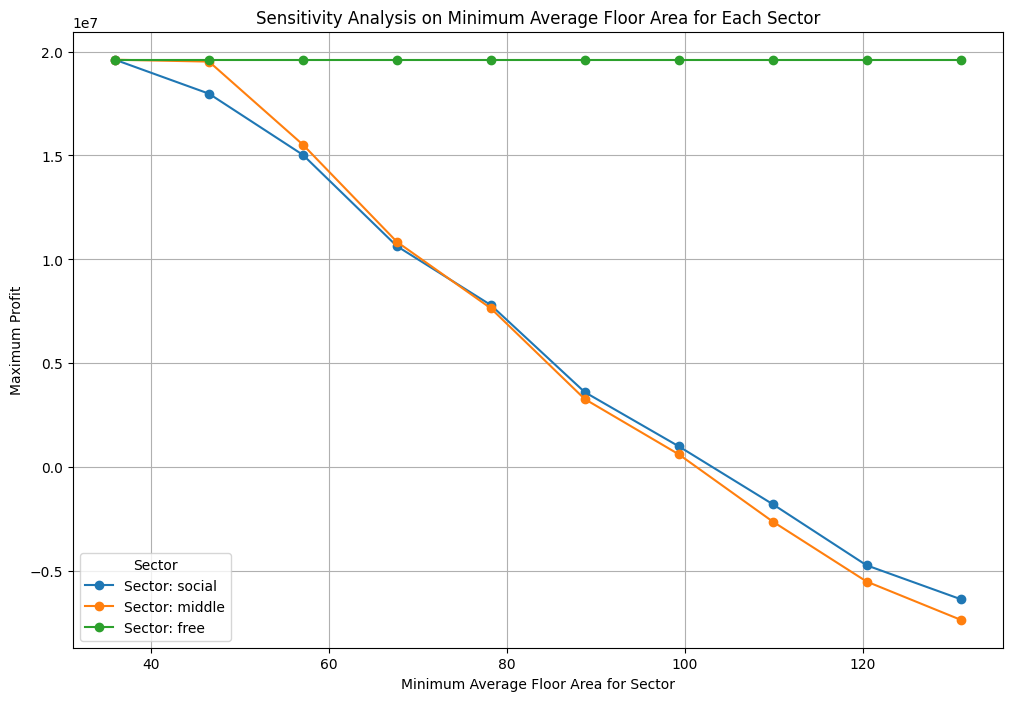


Results for sector: social
        gamma  objective_value
0   36.000000     1.960500e+07
1   46.555556     1.797057e+07
2   57.111111     1.502813e+07
3   67.666667     1.063825e+07
4   78.222222     7.804710e+06
5   88.777778     3.615578e+06
6   99.333333     1.011673e+06
7  109.888889    -1.770666e+06
8  120.444444    -4.713009e+06
9  131.000000    -6.339946e+06

Results for sector: middle
        gamma  objective_value
0   36.000000     1.960500e+07
1   46.555556     1.951452e+07
2   57.111111     1.551739e+07
3   67.666667     1.084629e+07
4   78.222222     7.648485e+06
5   88.777778     3.282980e+06
6   99.333333     6.270238e+05
7  109.888889    -2.606404e+06
8  120.444444    -5.493535e+06
9  131.000000    -7.330830e+06

Results for sector: free
        gamma  objective_value
0   36.000000     1.960500e+07
1   46.555556     1.960500e+07
2   57.111111     1.960500e+07
3   67.666667     1.960500e+07
4   78.222222     1.960500e+07
5   88.777778     1.960500e+07
6   99.333333     1

In [ ]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def sensitivity_analysis_on_gamma(profit_height_69, number_of_apartments, K=23):
    # Get the list of sectors from the data
    sectors = profit_height_69['sector'].unique().tolist()

    # Get available apartment areas from the data
    areas = sorted(number_of_apartments['area'].unique())
    min_area = min(areas)
    max_area = max(areas)

    # Define gamma values to test for each sector
    gamma_values = np.linspace(min_area, max_area, 10)  # Adjust the number of steps as needed

    # Initialize a dictionary to store results for each sector
    results = {i: [] for i in sectors}

    for i in sectors:
        print(f"Performing sensitivity analysis for sector: {i}")
        for gamma_value in gamma_values:
            # Set gamma for the current sector
            gamma = {}
            for si in sectors:
                gamma[si] = 0.0  # Set gamma for other sectors to 0
            gamma[i] = gamma_value  # Vary gamma for the current sector

            # Build the model with the current gamma
            model = housing_problem(profit_height_69, number_of_apartments, K=K, gamma=gamma)

            # Solve the model
            solver = pyo.SolverFactory('cbc')  # Replace 'glpk' with your solver of choice
            solver.options['tmlim'] = 60  # Set a time limit if desired
            result = solver.solve(model, tee=False)

            # Check if the solution is optimal
            if (result.solver.status == pyo.SolverStatus.ok) and \
               (result.solver.termination_condition == pyo.TerminationCondition.optimal):
                # Retrieve the objective value
                objective_value = pyo.value(model.obj)

                # Store the results
                results[i].append({
                    'gamma': gamma_value,
                    'objective_value': objective_value
                })
            else:
                print(f"Model not solved optimally for gamma = {gamma_value} for sector {i}. Status: {result.solver.status}")
                # Store NaN or some indicator
                results[i].append({
                    'gamma': gamma_value,
                    'objective_value': np.nan
                })

    # Convert results to DataFrames for analysis
    results_dfs = {}
    for i in results:
        df = pd.DataFrame(results[i])
        df.dropna(subset=['objective_value'], inplace=True)  # Drop rows with NaN objective values
        results_dfs[i] = df

    # Plotting the results for each sector
    plt.figure(figsize=(12, 8))
    for i in results_dfs:
        df = results_dfs[i]
        if not df.empty:
            plt.plot(df['gamma'], df['objective_value'], marker='o', label=f'Sector: {i}')

    plt.xlabel('Minimum Average Floor Area for Sector')
    plt.ylabel('Maximum Profit')
    plt.title('Sensitivity Analysis on Minimum Average Floor Area for Each Sector')
    plt.legend(title='Sector')
    plt.grid(True)
    plt.show()

    return results_dfs

# Example usage:
# Assuming profit_height_69 and number_of_apartments are already loaded as DataFrames
results_gamma = sensitivity_analysis_on_gamma(profit_height_69, number_of_apartments, K=23)

# Display the results for each sector
for i in results_gamma:
    print(f"\nResults for sector: {i}")
    print(results_gamma[i])


Performing sensitivity analysis for sector: social
Performing sensitivity analysis for sector: middle
Performing sensitivity analysis for sector: free


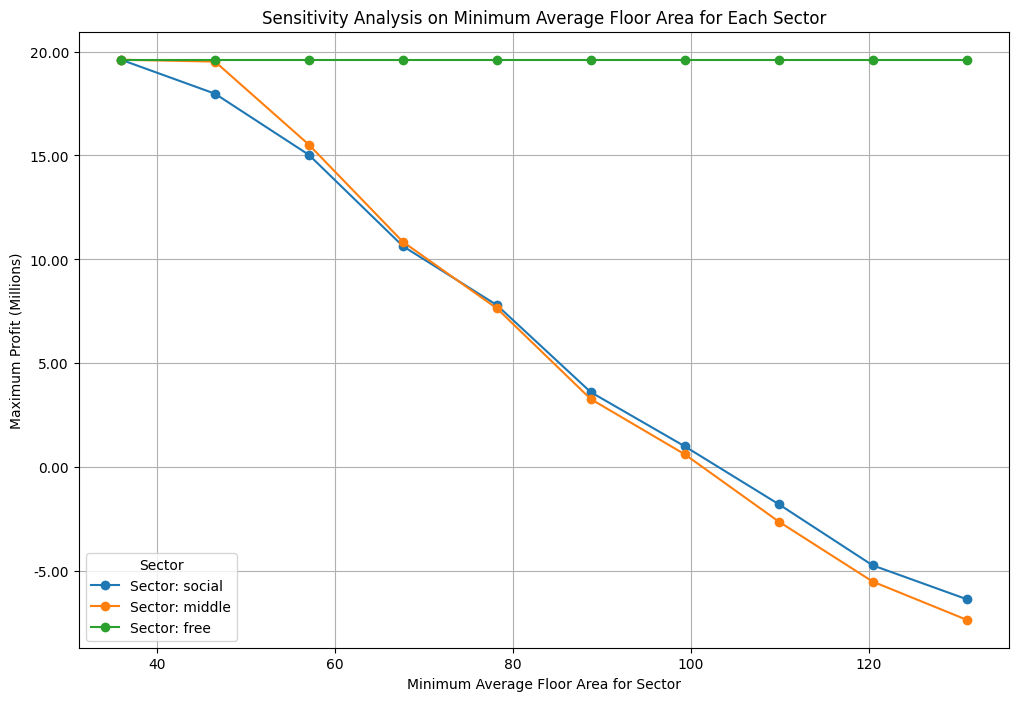


Results for sector: social
        gamma  maximum_profit  maximum_profit_millions
0   36.000000    1.960500e+07                19.605002
1   46.555556    1.797057e+07                17.970573
2   57.111111    1.502813e+07                15.028130
3   67.666667    1.063825e+07                10.638246
4   78.222222    7.804710e+06                 7.804710
5   88.777778    3.615578e+06                 3.615578
6   99.333333    1.011673e+06                 1.011673
7  109.888889   -1.770666e+06                -1.770666
8  120.444444   -4.713009e+06                -4.713009
9  131.000000   -6.339946e+06                -6.339946

Results for sector: middle
        gamma  maximum_profit  maximum_profit_millions
0   36.000000    1.960500e+07                19.605002
1   46.555556    1.951452e+07                19.514518
2   57.111111    1.551739e+07                15.517394
3   67.666667    1.084629e+07                10.846286
4   78.222222    7.648485e+06                 7.648485
5   88.77

In [ ]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Optional: Import ticker for formatting
import matplotlib.ticker as ticker

def sensitivity_analysis_on_gamma(profit_height_69, number_of_apartments, K=23):
    # Get the list of sectors from the data
    sectors = profit_height_69['sector'].unique().tolist()

    # Get available apartment areas from the data
    areas = sorted(number_of_apartments['area'].unique())
    min_area = min(areas)
    max_area = max(areas)

    # Define gamma values to test for each sector
    gamma_values = np.linspace(min_area, max_area, 10)  # Adjust the number of steps as needed

    # Initialize a dictionary to store results for each sector
    results = {i: [] for i in sectors}

    for i in sectors:
        print(f"Performing sensitivity analysis for sector: {i}")
        for gamma_value in gamma_values:
            # Set gamma for the current sector
            gamma = {}
            for si in sectors:
                gamma[si] = 0.0  # Set gamma for other sectors to 0
            gamma[i] = gamma_value  # Vary gamma for the current sector

            # Build the model with the current gamma
            model = housing_problem(profit_height_69, number_of_apartments, K=K, gamma=gamma)

            # Solve the model
            solver = pyo.SolverFactory('cbc')  # Replace 'glpk' with your solver of choice
            solver.options['tmlim'] = 60  # Set a time limit if desired
            result = solver.solve(model, tee=False)

            # Check if the solution is optimal
            if (result.solver.status == pyo.SolverStatus.ok) and \
               (result.solver.termination_condition == pyo.TerminationCondition.optimal):
                # Retrieve the maximum profit
                maximum_profit = pyo.value(model.obj)

                # Store the results
                results[i].append({
                    'gamma': gamma_value,
                    'maximum_profit': maximum_profit
                })
            else:
                print(f"Model not solved optimally for gamma = {gamma_value} for sector {i}. Status: {result.solver.status}")
                # Store NaN or some indicator
                results[i].append({
                    'gamma': gamma_value,
                    'maximum_profit': np.nan
                })

    # Convert results to DataFrames for analysis
    results_dfs = {}
    for i in results:
        df = pd.DataFrame(results[i])
        df.dropna(subset=['maximum_profit'], inplace=True)  # Drop rows with NaN maximum profit
        results_dfs[i] = df

    # Plotting the results for each sector
    plt.figure(figsize=(12, 8))
    for i in results_dfs:
        df = results_dfs[i]
        if not df.empty:
            # Convert maximum profit to millions
            df['maximum_profit_millions'] = df['maximum_profit'] / 1e6
            plt.plot(df['gamma'], df['maximum_profit_millions'], marker='o', label=f'Sector: {i}')

    plt.xlabel('Minimum Average Floor Area for Sector')
    plt.ylabel('Maximum Profit (Millions)')
    plt.title('Sensitivity Analysis on Minimum Average Floor Area for Each Sector')
    plt.legend(title='Sector')
    plt.grid(True)

    # Formatting y-axis ticks (optional)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    plt.show()

    return results_dfs

# Example usage:
# Assuming profit_height_69 and number_of_apartments are already loaded as DataFrames
results_gamma = sensitivity_analysis_on_gamma(profit_height_69, number_of_apartments, K=23)

# Display the results for each sector
for i in results_gamma:
    print(f"\nResults for sector: {i}")
    print(results_gamma[i])
